## Bayesian calibration of an SEIR model

![](https://web.stanford.edu/~ashishg/msande433/India_Model/india_model/imgs/flow.png)

**The SEIR model:** One of the most simple and commonly used mathematical models to describe the diffusion of an epidemic disease is the SEIR model, which aims to predict the number of infected, recovered, and dead individuals on the basis of the number of contacts, probability of disease transmission, incubation and infectious periods, and disease fatality rate.

The model takes the form
$$
\begin{aligned}
\frac{dS}{dt} & = -\beta \frac{S I}{N}, \\
\frac{dE}{dt} & = \beta \frac{S I}{N} - \alpha E, \\
\frac{dI}{dt} & = \alpha E - \gamma I, \\
\frac{dR}{dt} & =  \gamma I, \\
N & = S + E + I + R,
\end{aligned}
$$
where 
- $\alpha$: is the inverse of the incubation period (i.e. 1/(incubation time)), 
- $\beta$: is the average contact rate in the population, 
- $\gamma$: is the inverse of the mean infectious period (i.e. 1/(infectious time)), 
- $N$: is the total population size.



**A Bayesian inference task:** Given a data-set $\mathcal{D}=\{t_i, y_i\}_{i=1}^n$, containing $n$ noisy observations of the system state $x(t)=(S(t), E(t), I(t), R(t))$, i.e.
$$ y_i = x(t_i) + \epsilon, \quad \epsilon\sim\mathcal{N}(0,\sigma_n^2 I),$$ 
our goal is to infer the posterior distribution over the unkown SEIR model parameters $\theta=(\alpha, \beta, \gamma)$, i.e.
$$p(\theta|\mathcal{D}) \propto p(\mathcal{D}|\theta) p(\theta),$$
where the likelihood and priors can be defined as
$$
\begin{aligned}
p(\mathcal{D}|\theta) & = \text{Normal}(\text{ODEsolve}(x(t)|\alpha,\beta,\gamma), \sigma_n^2 I), \\
p(\alpha) & = \text{InvGam}(3, 1), \\
p(\beta) & = \text{Gam}(9, 0.1), \\
p(\gamma) & = \text{InvGam}(3, 1), \\
p(\sigma_n) & = \text{InvGam}(8, 0.5). \\
\end{aligned}
$$
Notice how we choose to assign Gamma and Inverse-Gamma priors for each parameter  in order to ensure positivity.

In this tutorial we'll see how MCMC sampling can be used for posterior inference. To this end can be used to generate samples from the target posterior distribution $p(\theta|\mathcal{D})$. To this end, let's start by generating a training data-set consisting of a reference noisy trajectory for the system states.

In [ ]:
import jax.numpy as np
from jax import random
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

In [ ]:
# Define the SEIR model dynamics
def SEIR(x, t, alpha, beta, gamma, N):
    S, E, I, R = x
    f1 = -beta * S * I / N
    f2 = beta * S * I / N - alpha * E
    f3 = alpha * E - gamma * I
    f4 = gamma * I
    dxdt = np.array([f1, f2, f3, f4])
    return dxdt

Text(0, 0.5, '$y(t)$')

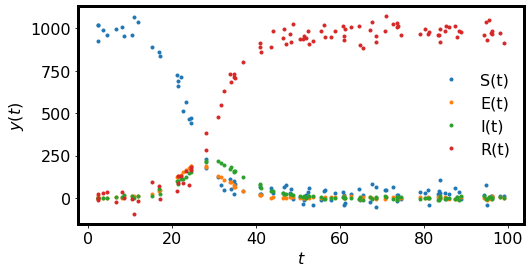

In [ ]:
# Set reference parameters
N = 1000.0
alpha = 1.0 / 3.0  # incubation period of three days
beta = 1.0  # infected person infects 1 other person per day
gamma = 1.0 / 4.0 # infections lasts four days
sigma_n = 0.1

# Initial conditions: one infected, rest susceptible
S0, E0, I0, R0 = 999.0, 0.0, 1.0, 0.0  
x0 = np.array([S0, E0, I0, R0])

# We will simulate over 100 days considering daily average values
key = random.PRNGKey(0)
t = np.sort(100.0*random.uniform(key, (100, )))

# Generate noisy time-series data
X_true = odeint(SEIR, x0, t, alpha, beta, gamma, N)
X = X_true + sigma_n*X_true.std(0)*random.normal(key, X_true.shape)

# Plot the reference trajectories
plt.figure(figsize = (8,4))
plt.plot(t, X[:,0], '.', label='S(t)')
plt.plot(t, X[:,1], '.', label='E(t)')
plt.plot(t, X[:,2], '.', label='I(t)')
plt.plot(t, X[:,3], '.', label='R(t)')
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')

## Markov Chain Monte Carlo
In order to perform MCMC sampling we need to evaluate the log-posterior
$$\log p(\theta|\mathcal{D}) = \log p(\mathcal{D}|\theta) + \log p(\theta).\ $$

Let's start by implementing some helper functions for evaluating the log-likelihood and the log-priors.

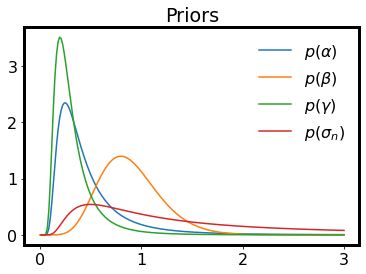

In [ ]:
from jax.lax import lgamma

# https://en.wikipedia.org/wiki/Normal_distribution
def norm_logpdf(x, loc=0.0, scale=1.0):
    return -np.log(scale) - 0.5*np.log(2.0*np.pi)-0.5*(x-loc)**2/scale**2

# https://en.wikipedia.org/wiki/Gamma_distribution
def gamma_logpdf(x, shape=0.0, scale=1.0):
    return (shape-1.0)*np.log(x) - x/scale - lgamma(shape) - shape*np.log(scale)

# https://en.wikipedia.org/wiki/Inverse-gamma_distribution
def invgamma_logpdf(x, shape=0.0, scale=1.0):
    return shape*np.log(scale) - (shape+1.0)*np.log(x) - scale/x - lgamma(shape)

# Plot priors
xx = np.linspace(0, 3, 200)
plt.plot(xx, np.exp(invgamma_logpdf(xx, 3.0, 1.0)), label=r'$p(\alpha)$')
plt.plot(xx, np.exp(gamma_logpdf(xx, 9.0, 0.1)), label=r'$p(\beta)$')
plt.plot(xx, np.exp(invgamma_logpdf(xx, 4.0, 1.0)), label=r'$p(\gamma)$')
plt.plot(xx, np.exp(invgamma_logpdf(xx, 1.0, 1.0)), label=r'$p(\sigma_n)$')
plt.title('Priors')
plt.legend(frameon=False)

In [ ]:
def log_posterior(params, batch):
    alpha, beta, gamma, sigma_n = params
    inputs, targets = batch
    x0, t, N = inputs
    # Log-likelihood
    outputs = odeint(SEIR, x0, t, alpha, beta, gamma, N)
    log_likelihood = np.sum(norm_logpdf(targets, loc=outputs, scale=sigma_n))
    # Log-prior
    log_prior = invgamma_logpdf(alpha, shape=3.0, scale=1.0) + \
                gamma_logpdf(beta, shape=9.0, scale=0.1) + \
                invgamma_logpdf(gamma, shape=4.0, scale=1.0) + \
                invgamma_logpdf(sigma_n, shape=1.0, scale=1.0)
    return log_likelihood + log_prior

In [ ]:
from jax import jit, vmap
from jax.lax import scan, cond
from functools import partial

def metropolis(log_prob, sigma):
    def init(rng_key, bounds):
        lb, ub = bounds
        dim = lb.shape[0]
        x0 = random.uniform(rng_key, (dim,), minval=lb, maxval=ub)
        return x0
    @partial(jit, static_argnums=(0,))
    def sample(num_samples, rng_key, init_state):
        def kernel(carry, i):
            key, state, logp = carry
            key, subkey = random.split(key)
            x = state + sigma * random.normal(subkey, state.shape)
            logp_prop = log_prob(x)
            u = random.uniform(key)
            cond = (u < np.exp(logp_prop - logp))
            state = np.where(cond, x, state)
            logp = np.where(cond, logp_prop, logp)
            return (key, state, logp), state
        logp = log_prob(init_state)
        _, samples = scan(kernel, (rng_key, init_state, logp), np.arange(num_samples))
        return samples
    return init, sample

In [ ]:
inputs = x0, t, N
targets = X
batch = inputs, targets

log_prob = lambda params: log_posterior(params, batch)

step_size = 0.005
init_fn, sample_fn = metropolis(log_prob, step_size)

num_chains = 2
burn_in = 5000
num_steps = 20000
key = random.PRNGKey(0)
keys = random.split(key, num_chains)
init_states = np.array([[0.2, 0.8, 0.3, 0.5], [0.4, 1.1, 0.5, 0.3]])
samples = vmap(sample_fn, in_axes=(None, 0, 0))(num_steps, keys, init_states)

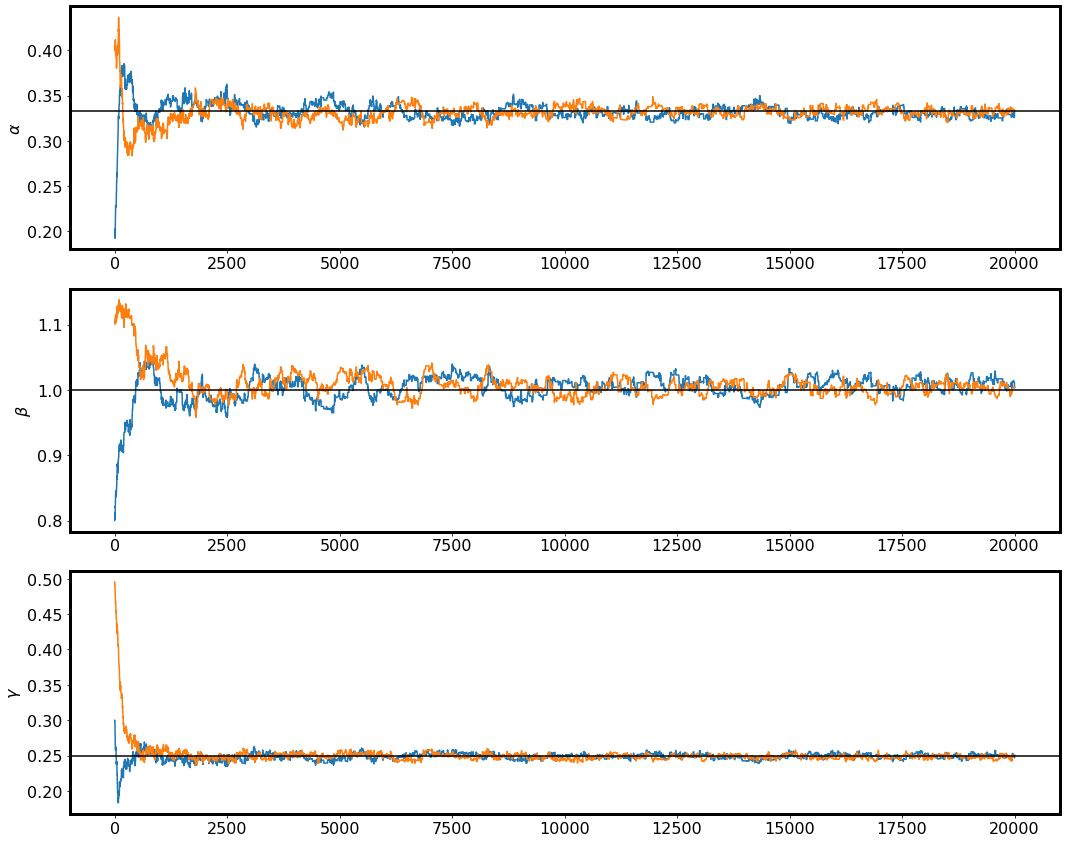

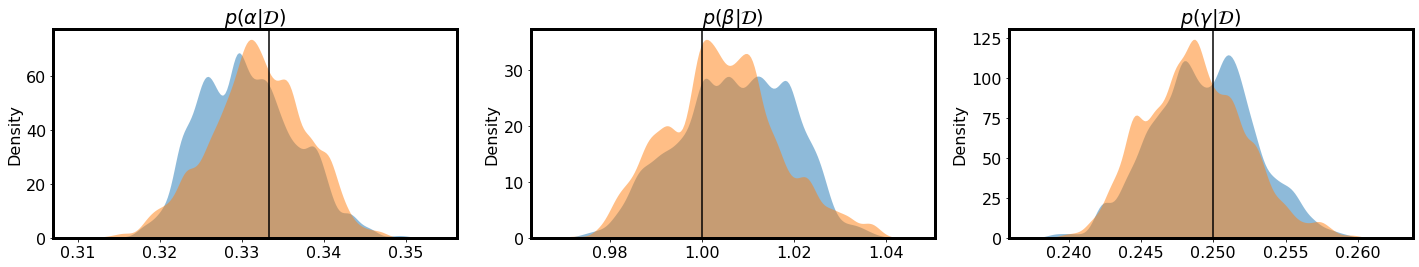

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
for i in range(num_chains):
    plt.plot(samples[i,:,0])
plt.axhline(alpha, color='black')
plt.ylabel(r'$\alpha$')
plt.subplot(3,1,2)
for i in range(num_chains):
    plt.plot(samples[i,:,1])
plt.axhline(beta, color='black')
plt.ylabel(r'$\beta$')
plt.subplot(3,1,3)
for i in range(num_chains):
    plt.plot(samples[i,:,2])
plt.axhline(gamma, color='black')
plt.ylabel(r'$\gamma$')
plt.tight_layout()

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
for i in range(num_chains):
    sns.kdeplot(samples[i,burn_in:,0], fill=True, alpha=.5, linewidth=0)
plt.axvline(alpha, color='k')
plt.title(r'$p(\alpha|\mathcal{D})$')
plt.subplot(1,3,2)
for i in range(num_chains):
    sns.kdeplot(samples[i,burn_in:,1], fill=True, alpha=.5, linewidth=0)
plt.axvline(beta, color='k')
plt.title(r'$p(\beta|\mathcal{D})$')
plt.subplot(1,3,3)
for i in range(num_chains):
    sns.kdeplot(samples[i,burn_in:,2], fill=True, alpha=.5, linewidth=0)
plt.axvline(gamma, color='k')
plt.title(r'$p(\gamma|\mathcal{D})$')
plt.tight_layout()

In [ ]:
from jax import vmap

@jit
def predictive_posterior(samples, batch):
    inputs, _ = batch
    x0, t, N = inputs
    outputs = odeint(SEIR, x0, t, samples[0], samples[1], samples[2], N)
    return outputs

num_traj = 50
chain_1 = samples[0,...]
chain_2 = samples[1,...]
traj_1 = vmap(predictive_posterior, in_axes=(0,None))(chain_1[-num_traj:,:], batch)
traj_2 = vmap(predictive_posterior, in_axes=(0,None))(chain_2[-num_traj:,:], batch)

Text(0, 0.5, '$y(t)$')

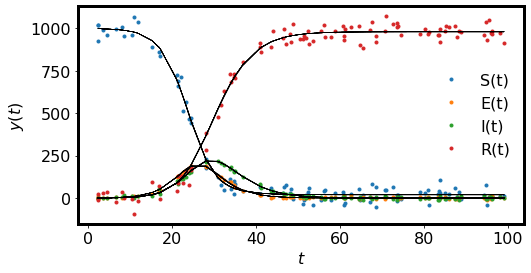

In [ ]:
# Plot the referenceand predicted trajectories
plt.figure(figsize = (8,4))
plt.plot(t, X[:,0], '.', label='S(t)')
plt.plot(t, X[:,1], '.', label='E(t)')
plt.plot(t, X[:,2], '.', label='I(t)')
plt.plot(t, X[:,3], '.', label='R(t)')
for i in range(num_traj):
    plt.plot(t, traj_1[i-num_traj,:],'k', lw=0.5, alpha=0.1)
    plt.plot(t, traj_2[i-num_traj,:],'k', lw=0.5, alpha=0.1)
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')

## How do we know this chain has converged to the posterior?


In [ ]:
import arviz as az

trace = {
    "alpha": samples[:,burn_in:,0],
    "beta": samples[:,burn_in:,1],
    "gamma": samples[:,burn_in:,2],
    "sigma_n": samples[:,burn_in:,3],
}
dataset = az.convert_to_inference_data(trace)

In [ ]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.331,0.006,0.320,0.342,0.001,0.000,90.0,231.0,1.03
beta,1.006,0.012,0.983,1.027,0.001,0.001,79.0,151.0,1.04
gamma,0.249,0.003,0.243,0.256,0.000,0.000,109.0,253.0,1.02
sigma_n,6.218,1.393,3.977,8.427,0.877,0.715,3.0,28.0,1.83


<Figure size 432x288 with 0 Axes>

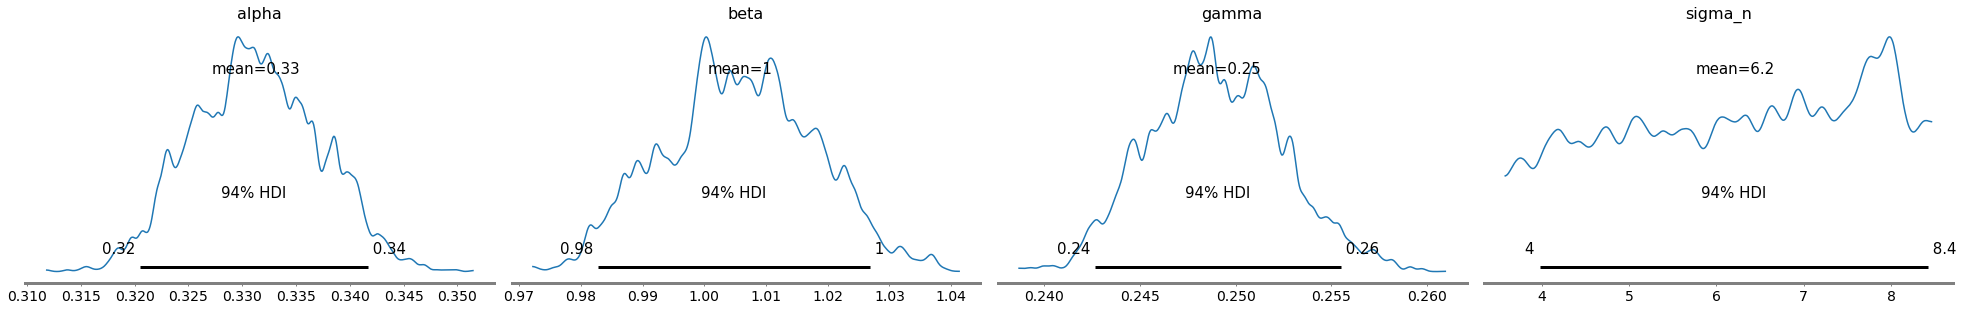

In [ ]:
plt.figure()
az.plot_posterior(dataset);
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

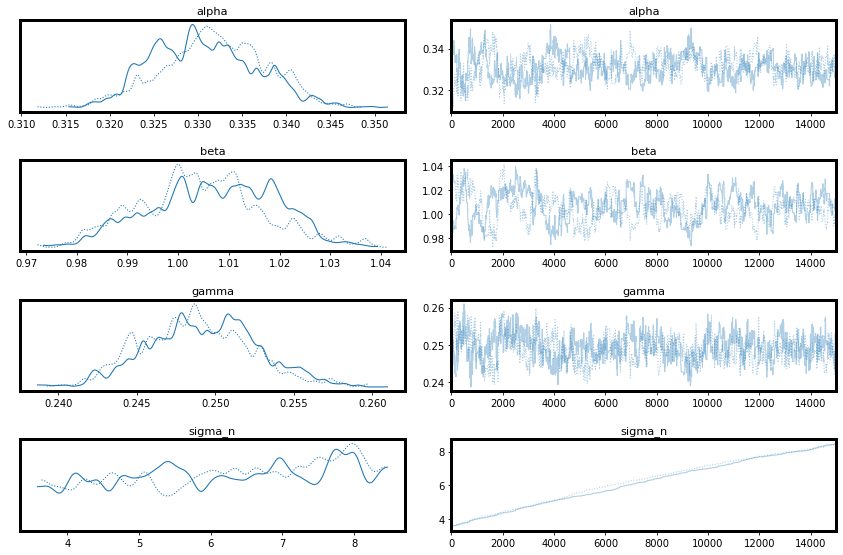

In [ ]:
plt.figure()
az.plot_trace(dataset);
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

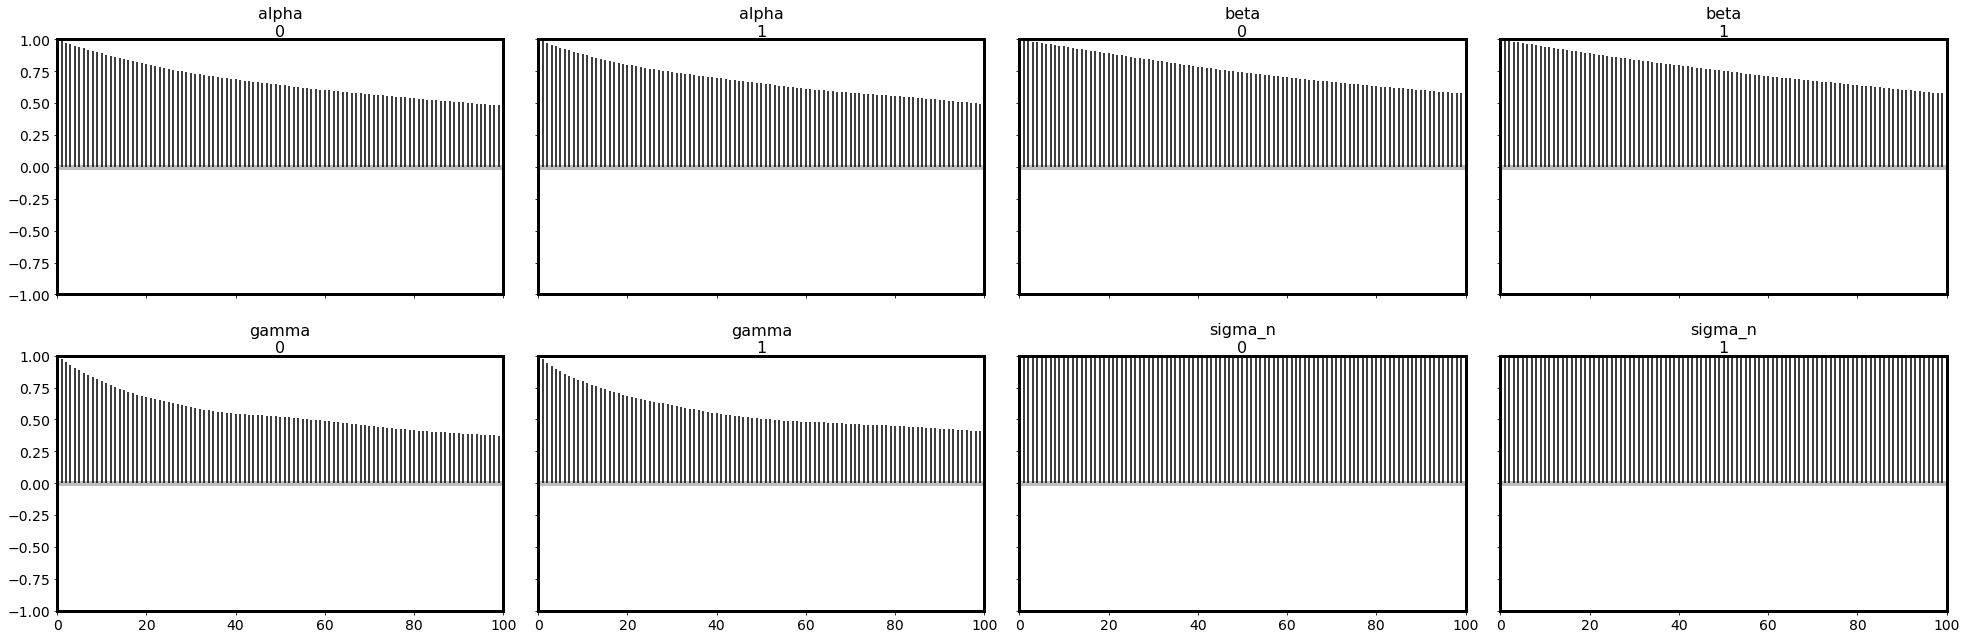

In [ ]:
plt.figure()
az.plot_autocorr(dataset);
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

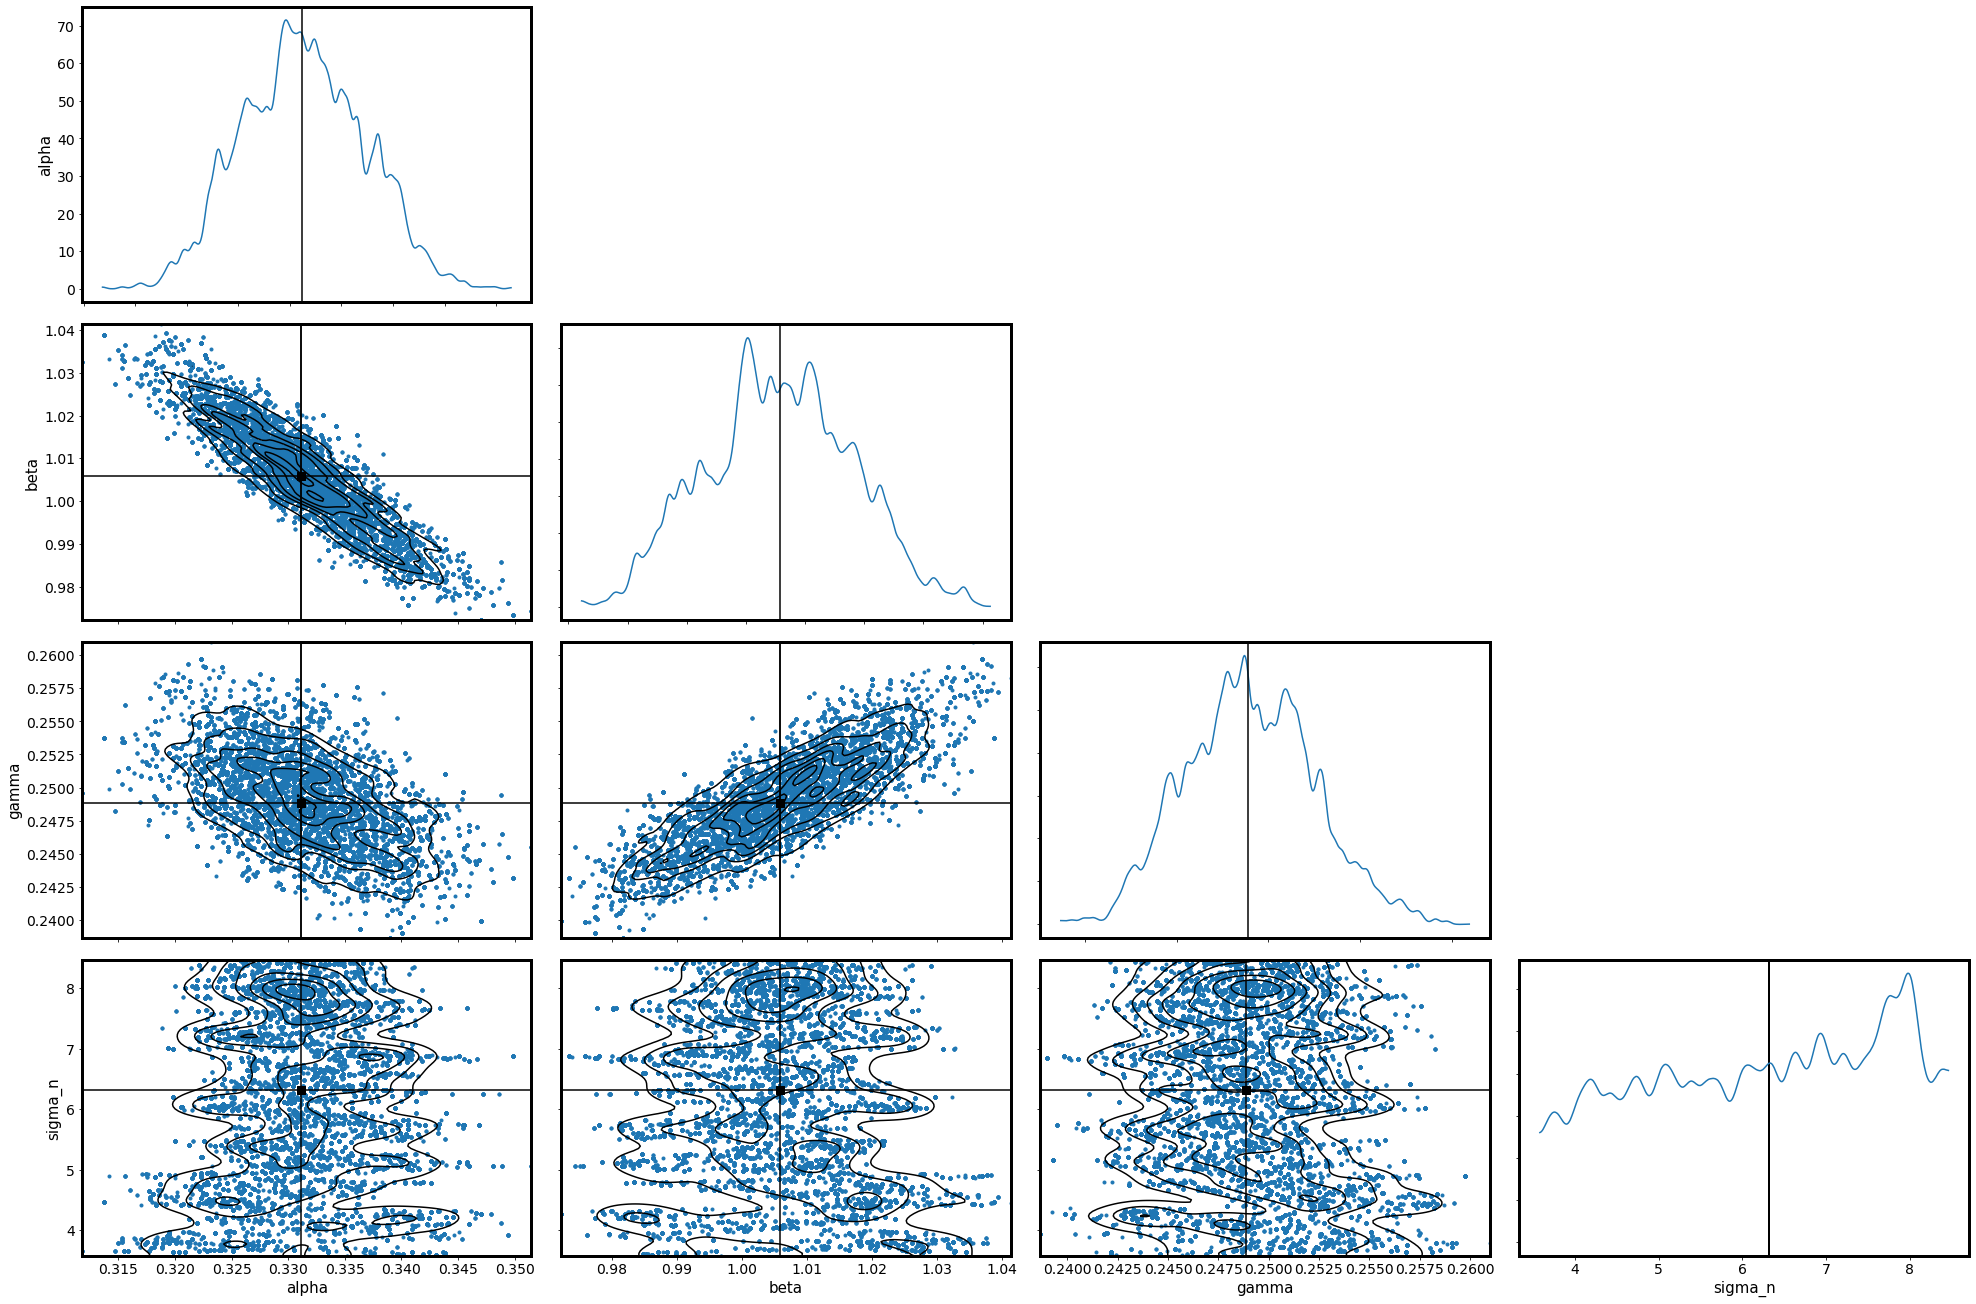

In [ ]:
plt.figure()
az.plot_pair(dataset, marginals=True, kind=["scatter", "kde"], kde_kwargs={"fill_last": False}, point_estimate="median");
plt.tight_layout()

In [ ]:
n = chain_1[burn_in:,:].shape[0]

W = (chain_1[burn_in:,:].std(0)**2 + chain_2[burn_in:,:].std(0)**2)/2
mean1 = chain_1[burn_in:,:].mean(0)
mean2 = chain_2[burn_in:,:].mean(0)
mean = (mean1 + mean2)/2
B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
var_theta = (1 - 1/n) * W + 1/n*B
print("Gelman-Rubin Diagnostic: ", np.sqrt(var_theta/W))

Gelman-Rubin Diagnostic:  [1.0100266 1.0120049 1.0080931 1.0012304]
